In [ ]:
# This is code for cz4042 final project
# Speech emotion recognition

# Keras
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import losses, models, optimizers
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras import backend as K
# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import SGD
# Other
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam
from matplotlib.pyplot import specgram
import pandas as pd
import os
import sys
import warnings
import pickle
# ignore warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [ ]:
# To mount google drive when using colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path for input files in google drive mounted
path = '/content/drive/My Drive/Colab Notebooks/inputs/'

In [ ]:
# load dataset
win_ts = 128
hop_ts = 64
only_radvess = True

melspec = np.load(path + 'mel_spec_data_1.npy')
ref = pd.read_pickle(path + "data_df_1.pkl")

In [ ]:
# for test data loaded, commented after test
# print(melspec.shape)
# print(melspec)

(4320, 25920)


In [ ]:
# print(ref.head)

<bound method NDFrame.head of      Emotion  ...                                               Path
0          5  ...  ./inputs/Audio_Speech_Actors_01-24/Actor_16/03...
1          6  ...  ./inputs/Audio_Speech_Actors_01-24/Actor_16/03...
2          6  ...  ./inputs/Audio_Speech_Actors_01-24/Actor_16/03...
3          5  ...  ./inputs/Audio_Speech_Actors_01-24/Actor_16/03...
4          7  ...  ./inputs/Audio_Speech_Actors_01-24/Actor_16/03...
...      ...  ...                                                ...
4315       2  ...  ./inputs/Audio_Speech_Actors_01-24/Actor_08/03...
4316       2  ...  ./inputs/Audio_Speech_Actors_01-24/Actor_08/03...
4317       2  ...  ./inputs/Audio_Speech_Actors_01-24/Actor_08/03...
4318       1  ...  ./inputs/Audio_Speech_Actors_01-24/Actor_08/03...
4319       1  ...  ./inputs/Audio_Speech_Actors_01-24/Actor_08/03...

[4320 rows x 4 columns]>


In [ ]:
# Split between train and test data, ratio of 1:3
X_train, X_test, y_train, y_test = train_test_split(
    melspec, ref.Emotion, test_size=0.25, shuffle=True, random_state=42)

X_train = X_train.squeeze()
X_test = X_test.squeeze()
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))
print(X_train.shape)

(3240, 25920)


In [ ]:
# for test only
# print(X_test.shape)
# print(y_train.shape)
# print(y_test.shape)

In [ ]:
# Reshape X train and test, for input into model, reshape the data being flattend in feature extraction part in order to easier save
X_train = X_train.reshape(3240, 2, 1, 60, 216)
X_test = X_test.reshape(1080, 2, 1, 60, 216)

input_y = Input(shape=X_train.shape[1:], name='Input_MELSPECT')

# for test only
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3240, 2, 1, 60, 216)
(1080, 2, 1, 60, 216)
(3240, 8)
(1080, 8)


In [ ]:
# Check the device used for training is GPU
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Selected device is {}'.format(device))

Selected device is cuda


In [ ]:
# Model Disign

## First LFLB (local feature learning block)
y = TimeDistributed(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_1')(input_y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_1')(y)
y = TimeDistributed(Activation('elu'), name='Activ_1')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'), name='MaxPool_1')(y)
y = TimeDistributed(Dropout(0.3), name='Drop_1')(y)     

## Second LFLB (local feature learning block)
y = TimeDistributed(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_2')(y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_2')(y)
y = TimeDistributed(Activation('elu'), name='Activ_2')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'), name='MaxPool_2')(y)
y = TimeDistributed(Dropout(0.3), name='Drop_2')(y)


## Third LFLB (local feature learning block)
y = TimeDistributed(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_3')(y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_3')(y)
y = TimeDistributed(Activation('elu'), name='Activ_3')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'), name='MaxPool_3')(y)
y = TimeDistributed(Dropout(0.4), name='Drop_3')(y)

## Fourth LFLB (local feature learning block)
y = TimeDistributed(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_4')(y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_4')(y)
y = TimeDistributed(Activation('elu'), name='Activ_4')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'), name='MaxPool_4')(y)
y = TimeDistributed(Dropout(0.4), name='Drop_4')(y)  

## Flat
y = TimeDistributed(Flatten(), name='Flat')(y)                      
                                
# Apply LSTM layer and one FC
y = LSTM(256, return_sequences=True, dropout=0.2, name='LSTM_1')(y)

# Dense layer
y = Flatten()(y)
y = Dense(64)(y)
y = Dropout(rate=0.4)(y)
y = BatchNormalization()(y)
y = Activation("relu")(y)
y = Dropout(rate=0.4)(y)

y = Dense(y_train.shape[1], activation='softmax', name='FC')(y)

model = Model(inputs=input_y, outputs=y)

model.compile(optimizer=Adam(lr=0.005, decay=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=30, verbose=1, mode='max')

# Fit model
# history = model.fit(X_train, y_train, batch_size=64, epochs=1, validation_data=(X_test, y_test), callbacks=[early_stopping])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                              batch_size=64, verbose=2, epochs=1500)

Epoch 1/1500
51/51 - 1s - loss: 2.3022 - accuracy: 0.1552 - val_loss: 2.2991 - val_accuracy: 0.1157
Epoch 2/1500
51/51 - 1s - loss: 2.0633 - accuracy: 0.1809 - val_loss: 2.1198 - val_accuracy: 0.1620
Epoch 3/1500
51/51 - 1s - loss: 1.9320 - accuracy: 0.2512 - val_loss: 1.8840 - val_accuracy: 0.2537
Epoch 4/1500
51/51 - 1s - loss: 1.8657 - accuracy: 0.2651 - val_loss: 1.7663 - val_accuracy: 0.3093
Epoch 5/1500
51/51 - 1s - loss: 1.8072 - accuracy: 0.3031 - val_loss: 1.6902 - val_accuracy: 0.3213
Epoch 6/1500
51/51 - 1s - loss: 1.7799 - accuracy: 0.3077 - val_loss: 1.8347 - val_accuracy: 0.2796
Epoch 7/1500
51/51 - 1s - loss: 1.7690 - accuracy: 0.3278 - val_loss: 1.7989 - val_accuracy: 0.2583
Epoch 8/1500
51/51 - 1s - loss: 1.7233 - accuracy: 0.3426 - val_loss: 1.6076 - val_accuracy: 0.4213
Epoch 9/1500
51/51 - 1s - loss: 1.6883 - accuracy: 0.3481 - val_loss: 1.6082 - val_accuracy: 0.3787
Epoch 10/1500
51/51 - 1s - loss: 1.6561 - accuracy: 0.3747 - val_loss: 1.6741 - val_accuracy: 0.3556

In [ ]:
# Save accuracy to npy file for further use
np.save(path + 'lstm_acc.npy', np.array(history.history['accuracy']))

In [ ]:
# test only
acc = np.load(path + 'lstm_acc.npy')
print(acc)

[0.15524691 0.1808642  0.25123456 ... 0.97037035 0.97098768 0.96666664]


In [ ]:
# Save val_accuracy to npy file for further use
np.save(path + 'lstm_accval.npy', np.array(history.history['val_accuracy']))

In [ ]:
# test only
valacc = np.load(path + 'lstm_accval.npy')
print(valacc)
print(valacc.shape)

[0.11574074 0.16203703 0.25370371 ... 0.96296299 0.96666664 0.96018517]
(1500,)


In [ ]:
# Save loss to npy file for further use
np.save(path + 'lstm_lss.npy', np.array(history.history['loss']))

In [ ]:
# test only
lss = np.load(path + 'lstm_lss.npy')
print(lss)
print(lss.shape)

[2.30216551 2.06329989 1.93199944 ... 0.10312334 0.09958569 0.10222448]
(1500,)


In [ ]:
# Save val_loss to npy file for further use
np.save(path + 'lstm_vallss.npy', np.array(history.history['val_loss']))

In [ ]:
# test only
vallss = np.load(path + 'lstm_vallss.npy')
print(vallss)
print(vallss.shape)

[2.29909086 2.11976123 1.88395727 ... 0.18974981 0.18605693 0.19944122]
(1500,)


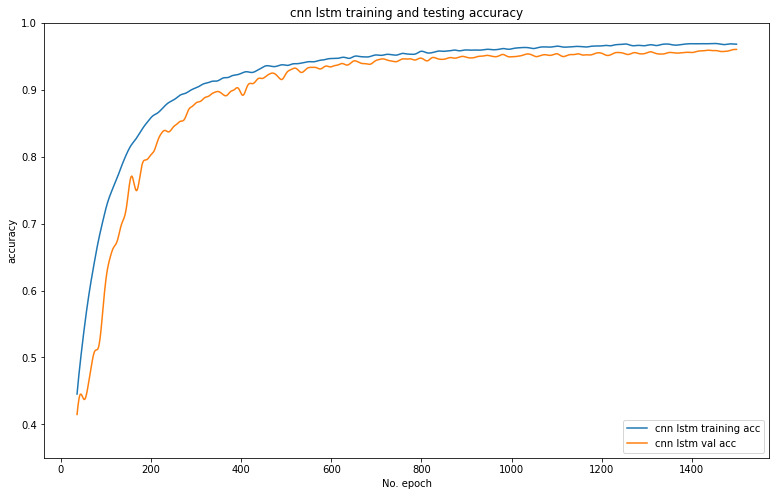

In [ ]:
# plot curves - cnn lstm training and test accuracy
fig=plt.gcf()

history.history['accuracy'] = pd.Series(history.history['accuracy']).rolling(window=10).mean()
history.history['val_accuracy'] = pd.Series(history.history['val_accuracy']).rolling(window=10).mean()

axes = plt.gca()
axes.set_ylim([0.35,1])

plt.plot(history.history['accuracy'], label='cnn lstm training acc', c='#1f77b4')
plt.plot(history.history['val_accuracy'], label='cnn lstm val acc', c='#ff7f0e')

plt.title('cnn lstm training and testing accuracy')
plt.ylabel('accuracy')
plt.xlabel('No. epoch')
plt.legend(loc="lower right")

fig.set_size_inches(13, 8, forward=True)
plt.show()

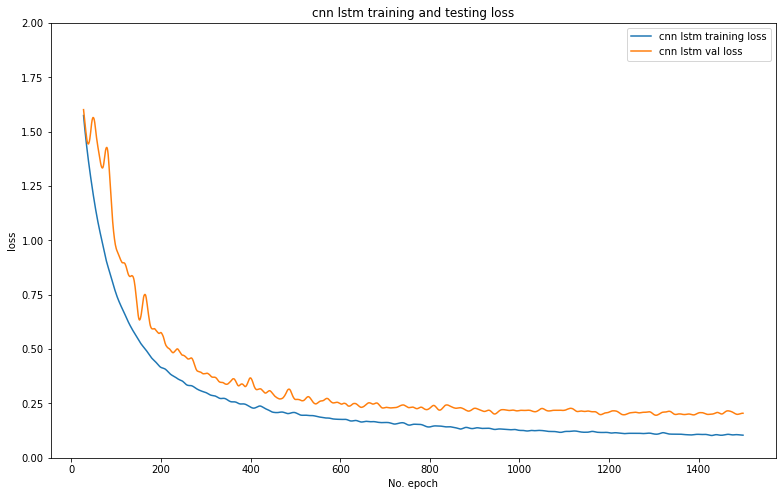

In [ ]:
# plot curves - cnn lstm training and test loss
fig=plt.gcf()

axes = plt.gca()
axes.set_ylim([0,2])

history.history['loss'] = pd.Series(history.history['loss']).rolling(window=10).mean()
history.history['val_loss'] = pd.Series(history.history['val_loss']).rolling(window=10).mean()

plt.plot(history.history['loss'], label='cnn lstm training loss', c='#1f77b4')
plt.plot(history.history['val_loss'], label='cnn lstm val loss', c='#ff7f0e')

plt.title('cnn lstm training and testing loss')
plt.ylabel('loss')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")

fig.set_size_inches(13, 8, forward=True)
plt.show()